<a href="https://colab.research.google.com/github/Israelchguevara/Analisis-de-Tolerancia-a-la-Glucosa-/blob/main/An%C3%A1lisis_de_Tolerancia_a_la_Glucosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto: Análisis de Tolerancia a la Glucosa con Python

Este cuaderno documenta, paso a paso, un **pipeline de análisis estadístico** sobre tolerancia a la glucosa en dos grupos de personas (jóvenes y adultos).  
Incluye **EDA**, **pruebas de normalidad**, **modelado lineal** y **contrastes/inferencias**.

**Dataset mínimo esperado** (CSV):
- `grupo` (1 = <30 años; 2 = >30 años)
- `glucosa_basal` (mg/dL)
- `glucosa_60min` (mg/dL)

> Ejecuta las celdas en orden. En Google Colab puedes usar `Entorno de ejecución → Ejecutar todo`.



## Objetivos del proyecto
1. **EDA por grupo** de la glucosa basal y a 60 minutos (tablas de medidas y gráficos).
2. Evaluar **simetría y curtosis** (especial foco en adultos).
3. Calcular **cuartiles** y **box-plot** (jóvenes), identificando **outliers**.
4. Comprobar **normalidad** de `glucosa_60min` por grupo (prueba + visual).
5. Estudiar la **relación** `glucosa_basal` → `glucosa_60min` (jóvenes): correlación y **regresión lineal** con predicción.
6. **Inferencia**: intervalos y contrastes sobre medias y proporciones; contraste emparejado basal vs 60 min (adultos).



## 0) Dependencias e imports
Instalamos (si es necesario) y cargamos bibliotecas. Este notebook usa `pandas`, `numpy`, `scipy`, `matplotlib`, `seaborn`, y `statsmodels`.


In [1]:
# En Colab, descomenta si falta algo:
# !pip install pandas numpy scipy matplotlib seaborn statsmodels

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
print("Versions → pandas:", pd.__version__, "| numpy:", np.__version__)

Versions → pandas: 2.2.2 | numpy: 2.0.2



## 1) Carga de datos
Por defecto, se espera el archivo en `./data/ARCHIVODATOSEVALUACION24csv.csv`.  
Si estás en Colab y no tienes el archivo en esa ruta, puedes **subirlo manualmente**.


In [2]:
# Ruta por defecto
DATA_PATH = "data/ARCHIVODATOSEVALUACION24csv.csv"

# Si no existe, intentar carga manual (Colab)
if not os.path.exists(DATA_PATH):
    try:
        from google.colab import files  # type: ignore
        print("No se encontró el CSV en", DATA_PATH)
        print("Elige tu archivo CSV local para subirlo...")
        uploaded = files.upload()
        # Tomar el primer archivo subido
        DATA_PATH = list(uploaded.keys())[0]
        print("Cargado:", DATA_PATH)
    except Exception as e:
        raise FileNotFoundError("No se pudo localizar el CSV. Sube el archivo manualmente o coloca el CSV en ./data/.") from e

raw = pd.read_csv(DATA_PATH)
print("Dimensiones:", raw.shape)
raw.head()

No se encontró el CSV en data/ARCHIVODATOSEVALUACION24csv.csv
Elige tu archivo CSV local para subirlo...


Saving ARCHIVODATOSEVALUACION24csv.csv to ARCHIVODATOSEVALUACION24csv.csv
Cargado: ARCHIVODATOSEVALUACION24csv.csv
Dimensiones: (65, 3)


,Grupo de control,Nivel glucosa basal,Nivel glucosa 60 min
0,1,90,136
1,1,82,151
2,1,80,148
3,1,75,138
4,1,74,141



## 2) Estandarización de columnas
Se normalizan nombres de columnas para trabajar de forma robusta, incluso si tu CSV usa etiquetas alternativas.


In [3]:
def _normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mapping = {c: c.strip().lower().replace(" ", "_") for c in df.columns}
    df.rename(columns=mapping, inplace=True)
    return df

def _guess_column(df: pd.DataFrame, candidates):
    cols = list(df.columns)
    for cand in candidates:
        for c in cols:
            if cand == c:
                return c
    for cand in candidates:
        for c in cols:
            if cand in c:
                return c
    return None

df = _normalize_cols(raw)

grupo_col   = _guess_column(df, ["grupo", "group"])
basal_col   = _guess_column(df, ["glucosa_basal", "basal", "glucosa0", "glucosa_basal_mg/dl"])
g60_col     = _guess_column(df, ["glucosa_60min", "glucosa60", "glucosa_60", "glucosa_60_min", "postcarga", "a_60_min"])

if not all([grupo_col, basal_col, g60_col]):
    raise KeyError(f"No se pudieron identificar columnas. Detectado → grupo={grupo_col}, basal={basal_col}, 60min={g60_col}")

df = df[[grupo_col, basal_col, g60_col]].copy()
df.columns = ["grupo", "glucosa_basal", "glucosa_60min"]

df["glucosa_basal"] = pd.to_numeric(df["glucosa_basal"], errors="coerce")
df["glucosa_60min"] = pd.to_numeric(df["glucosa_60min"], errors="coerce")
df["grupo"] = pd.to_numeric(df["grupo"], errors="coerce").astype("Int64")

df = df.dropna(subset=["grupo", "glucosa_basal", "glucosa_60min"]).copy()
df = df[df["grupo"].isin([1, 2])].copy()

print(df.dtypes)
df.head()

grupo            Int64
glucosa_basal    int64
glucosa_60min    int64
dtype: object


,grupo,glucosa_basal,glucosa_60min
0,1,90,136
1,1,82,151
2,1,80,148
3,1,75,138
4,1,74,141



## 3) EDA por grupo
Medidas de **centralidad y dispersión** para `glucosa_basal` y `glucosa_60min` por grupo.


In [4]:
def describe_grouped(d: pd.DataFrame, value: str) -> pd.DataFrame:
    g = d.groupby("grupo")[value]
    desc = g.agg(["count","mean","median","std","min","max"])
    desc["iqr"] = g.quantile(0.75) - g.quantile(0.25)
    desc["cv"] = desc["std"] / desc["mean"]
    return desc

desc_basal = describe_grouped(df, "glucosa_basal")
desc_60    = describe_grouped(df, "glucosa_60min")

print("Glucosa basal por grupo")
display(desc_basal)
print("\nGlucosa 60 min por grupo")
display(desc_60)

Glucosa basal por grupo


,count,mean,median,std,min,max,iqr,cv
grupo,,,,,,,,
1,35,85.0286,82.0000,9.3792,65,104,12.0000,0.1103
2,30,90.8333,90.5000,8.4612,77,106,13.2500,0.0932



Glucosa 60 min por grupo


,count,mean,median,std,min,max,iqr,cv
grupo,,,,,,,,
1,35,147.9429,148.0000,9.5485,131,172,12.0000,0.0645
2,30,173.2667,172.0000,12.3090,152,198,20.0000,0.0710



### Distribuciones (histogramas)


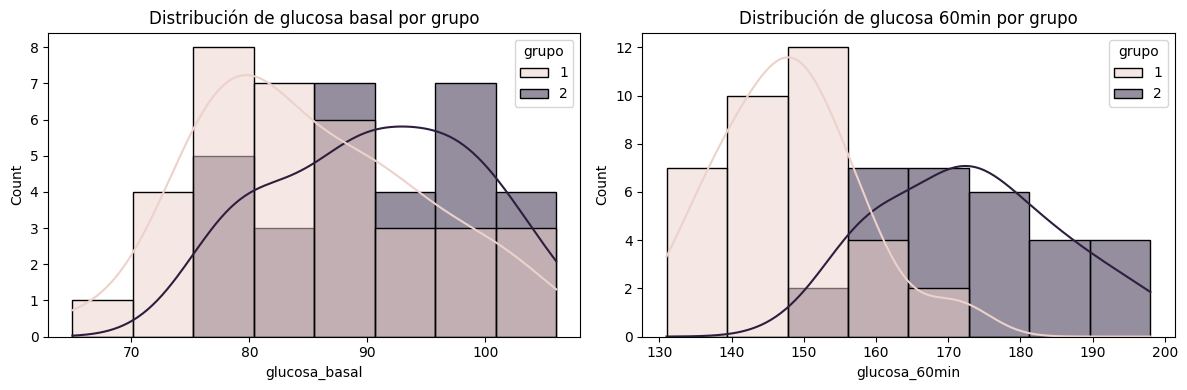

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
for i, col in enumerate(["glucosa_basal", "glucosa_60min"]):
    sns.histplot(data=df, x=col, hue="grupo", kde=True, ax=axes[i])
    axes[i].set_title(f"Distribución de {col.replace('_',' ')} por grupo")
plt.tight_layout()
plt.show()


## 4) Simetría y curtosis (adultos, grupo 2)


In [6]:
adultos = df[df["grupo"] == 2].copy()
skew_basal = stats.skew(adultos["glucosa_basal"], bias=False, nan_policy='omit')
kurt_basal = stats.kurtosis(adultos["glucosa_basal"], fisher=True, bias=False, nan_policy='omit')

print(f"Asimetría (skew) basal adultos: {skew_basal:,.4f}")
print(f"Curtosis (Fisher) basal adultos: {kurt_basal:,.4f}")

Asimetría (skew) basal adultos: -0.0801
Curtosis (Fisher) basal adultos: -1.0258



## 5) Cuartiles y box-plot (jóvenes, grupo 1)


Q1=78.50, Q2=82.00, Q3=90.50, IQR=12.00
Outliers detectados (regla 1.5*IQR): 0 filas


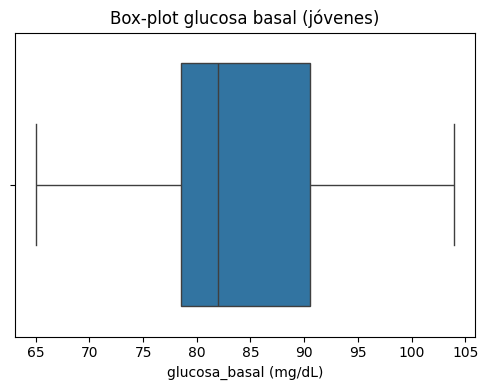

In [7]:
jovenes = df[df["grupo"] == 1].copy()
q1 = jovenes["glucosa_basal"].quantile(0.25)
q2 = jovenes["glucosa_basal"].quantile(0.50)
q3 = jovenes["glucosa_basal"].quantile(0.75)
iqr = q3 - q1
lim_inf = q1 - 1.5*iqr
lim_sup = q3 + 1.5*iqr
outliers = jovenes[(jovenes["glucosa_basal"] < lim_inf) | (jovenes["glucosa_basal"] > lim_sup)]

print(f"Q1={q1:.2f}, Q2={q2:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}")
print(f"Outliers detectados (regla 1.5*IQR): {outliers.shape[0]} filas")

plt.figure(figsize=(5,4))
sns.boxplot(x=jovenes["glucosa_basal"])
plt.title("Box-plot glucosa basal (jóvenes)")
plt.xlabel("glucosa_basal (mg/dL)")
plt.tight_layout()
plt.show()


## 6) Normalidad de `glucosa_60min` por grupo
Se aplican pruebas de **Shapiro–Wilk** (si n ≤ 5000) y **QQ-plot** como apoyo visual.


Grupo 1 (jóvenes)
glucosa_60min (jóvenes): Shapiro-Wilk W=0.9736, p-value=0.5493, n=35


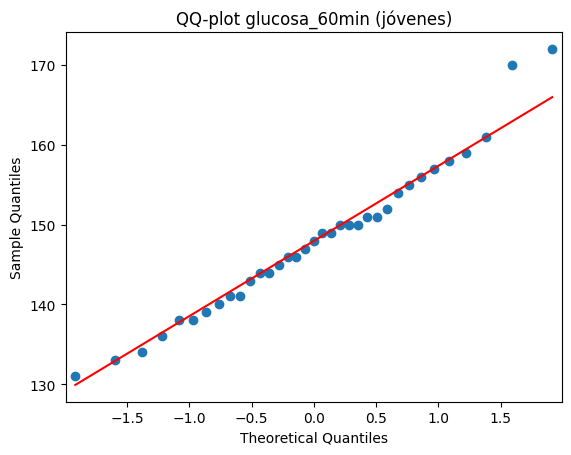


Grupo 2 (adultos)
glucosa_60min (adultos): Shapiro-Wilk W=0.9660, p-value=0.4357, n=30


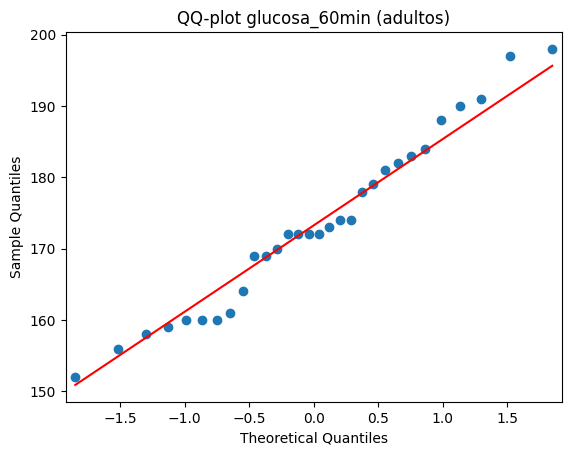

In [8]:
def normality_report(series: pd.Series, label: str):
    s = series.dropna()
    n = s.shape[0]
    if 3 <= n <= 5000:
        w, p = stats.shapiro(s)
        print(f"{label}: Shapiro-Wilk W={w:.4f}, p-value={p:.4f}, n={n}")
    else:
        print(f"{label}: n={n} fuera de rango para Shapiro (usa QQ-plot como referencia)")

    sm.qqplot(s, line='s')
    plt.title(f"QQ-plot {label}")
    plt.show()

print("Grupo 1 (jóvenes)")
normality_report(df.loc[df["grupo"]==1, "glucosa_60min"], "glucosa_60min (jóvenes)")
print("\nGrupo 2 (adultos)")
normality_report(df.loc[df["grupo"]==2, "glucosa_60min"], "glucosa_60min (adultos)")


## 7) Relación `glucosa_basal` vs `glucosa_60min` (jóvenes)
- **Dispersión** y **correlación** de Pearson.
- **Modelo lineal**: `glucosa_60min ~ glucosa_basal`.
- **Predicción** para `glucosa_basal = 83 mg/dL`.
- **% no explicado** por el modelo (`1 − R²`).
- **Efecto** de un aumento de **+5 mg/dL** en basal (`pendiente × 5`).


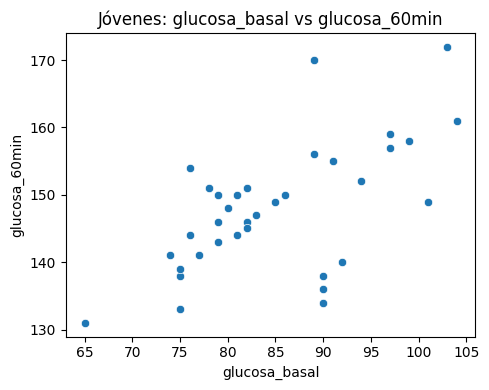

Correlación de Pearson r=0.6105 (p=0.0001)
                            OLS Regression Results                            
Dep. Variable:          glucosa_60min   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     19.61
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           9.83e-05
Time:                        20:58:23   Log-Likelihood:                -119.97
No. Observations:                  35   AIC:                             243.9
Df Residuals:                      33   BIC:                             247.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Int

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,146.6820,1.3283,143.9794,149.3845,130.8330,162.5310


Porcentaje no explicado (1 - R²): 62.72%
Efecto estimado de +5 mg/dL en basal sobre 60 min: 3.11 mg/dL


In [9]:
df_young = df[df["grupo"]==1].copy()

plt.figure(figsize=(5,4))
sns.scatterplot(data=df_young, x="glucosa_basal", y="glucosa_60min")
plt.title("Jóvenes: glucosa_basal vs glucosa_60min")
plt.tight_layout()
plt.show()

r, pval = stats.pearsonr(df_young["glucosa_basal"], df_young["glucosa_60min"])
print(f"Correlación de Pearson r={r:.4f} (p={pval:.4f})")

model = smf.ols("glucosa_60min ~ glucosa_basal", data=df_young).fit()
print(model.summary())

pred_input = pd.DataFrame({"glucosa_basal":[83]})
pred = model.get_prediction(pred_input).summary_frame(alpha=0.05)
print("\nPredicción para glucosa_basal = 83 mg/dL:")
display(pred)

r2 = model.rsquared
print(f"Porcentaje no explicado (1 - R²): {(1-r2)*100:.2f}%")

slope = model.params["glucosa_basal"]
print(f"Efecto estimado de +5 mg/dL en basal sobre 60 min: {slope*5:.2f} mg/dL")


## 8) Inferencia: intervalos y contrastes
- **Media jóvenes (basal) ≈ 88 mg/dL**: IC 95%/99% y prueba t de una muestra.
- **Diferencia de medias (adultos − jóvenes) en basal**: IC 95% y t de dos muestras (Levene para varianzas).
- **Proporción con basal > 95 mg/dL (muestra total)**: IC 98% y contraste `H₀: p = 0.15` a α=0.05.
- **Emparejado adultos (basal vs 60 min)**: t pareada a α=0.05.


In [12]:
young_basal = df.loc[df["grupo"]==1, "glucosa_basal"].dropna()
adult_basal = df.loc[df["grupo"]==2, "glucosa_basal"].dropna()
total_basal = df["glucosa_basal"].dropna()

mu0 = 88.0
n = young_basal.size

def mean_ci(sample, alpha=0.05):
    m = sample.mean()
    s = sample.std(ddof=1)
    n = sample.size
    se = s/np.sqrt(n)
    tcrit = stats.t.ppf(1-alpha/2, df=n-1)
    return m - tcrit*se, m + tcrit*se

ci95 = mean_ci(young_basal, 0.05)
ci99 = mean_ci(young_basal, 0.01)

t_stat, p_value = stats.ttest_1samp(young_basal, popmean=mu0)
print(f"Media jóvenes vs {mu0} mg/dL → t={t_stat:.4f}, p={p_value:.4f}, n={n}")
print(f"IC 95% jóvenes: ({ci95[0]:.2f}, {ci95[1]:.2f})")
print(f"IC 99% jóvenes: ({ci99[0]:.2f}, {ci99[1]:.2f})")

lev_stat, lev_p = stats.levene(adult_basal, young_basal, center='median')
equal_var = lev_p > 0.05
t2_stat, t2_p = stats.ttest_ind(adult_basal, young_basal, equal_var=equal_var)
print(f"\nLevene p={lev_p:.4f} → equal_var={equal_var}")
print(f"Diferencia de medias (adultos - jóvenes) → t={t2_stat:.4f}, p={t2_p:.4f}")

def diff_means_ci(a, b, alpha=0.05, assume_equal=True):
    na, nb = a.size, b.size
    ma, mb = a.mean(), b.mean()
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    if assume_equal:
        sp2 = ((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2)
        se = np.sqrt(sp2*(1/na + 1/nb))
        dfree = na+nb-2
    else:
        se = np.sqrt(sa2/na + sb2/nb)
        dfree = (sa2/na + sb2/nb)**2 / ((sa2**2)/((na**2)*(na-1)) + (sb2**2)/((nb**2)*(nb-1)))
    tcrit = stats.t.ppf(1-alpha/2, df=dfree)
    diff = ma - mb
    return (diff - tcrit*se, diff + tcrit*se)

ci_diff = diff_means_ci(adult_basal, young_basal, 0.05, assume_equal=equal_var)
print(f"IC 95% (adultos - jóvenes) para la media de basal: ({ci_diff[0]:.2f}, {ci_diff[1]:.2f})")

threshold = 95.0
x = int((total_basal > threshold).sum())
N = total_basal.size
p_hat = x/N

z = stats.norm.ppf(1 - 0.01)  # 98%
se = np.sqrt(p_hat*(1-p_hat)/N)
ci98 = (p_hat - z*se, p_hat + z*se)

p0 = 0.15
z_stat = (p_hat - p0)/np.sqrt(p0*(1-p0)/N)
p_val = 2*(1 - stats.norm.cdf(abs(z_stat)))

print(f"\nProporción basal > {threshold} mg/dL → x={x}, N={N}, p̂={p_hat:.4f}")
print(f"IC 98% aprox.: ({ci98[0]:.4f}, {ci98[1]:.4f})")
print(f"Contraste H0: p={p0} → z={z_stat:.4f}, p={p_val:.4f}")

adult_basal_vals = df.loc[df['grupo']==2, 'glucosa_basal'].values
adult_60_vals    = df.loc[df['grupo']==2, 'glucosa_60min'].values
m = min(len(adult_basal_vals), len(adult_60_vals))
tpaired_stat, tpaired_p = stats.ttest_rel(adult_basal_vals[:m], adult_60_vals[:m])
print(f"\nPareado adultos (basal vs 60 min) → t={tpaired_stat:.4f}, p={tpaired_p:.4f}, n={m}")

Media jóvenes vs 88.0 mg/dL → t=-1.8743, p=0.0695, n=35
IC 95% jóvenes: (81.81, 88.25)
IC 99% jóvenes: (80.70, 89.35)

Levene p=0.6786 → equal_var=True
Diferencia de medias (adultos - jóvenes) → t=2.6014, p=0.0116
IC 95% (adultos - jóvenes) para la media de basal: (1.35, 10.26)

Proporción basal > 95.0 mg/dL → x=17, N=65, p̂=0.2615
IC 98% aprox.: (0.1347, 0.3883)
Contraste H0: p=0.15 → z=2.5184, p=0.0118

Pareado adultos (basal vs 60 min) → t=-31.2665, p=0.0000, n=30



## 9) Exportar figuras (opcional)


In [13]:
os.makedirs("figures", exist_ok=True)
# plt.savefig("figures/ejemplo.png", dpi=150, bbox_inches="tight")


## 10) Notas finales
- Los resultados dependen del **dataset** concreto.
- Se recomienda añadir **diagnósticos** adicionales del modelo y **análisis de sensibilidad** si procede.
- Este cuaderno está pensado para ser **claro, reproducible y extensible**.
